# Baseline: ecapa

In [1]:
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import os
import matplotlib.pyplot as plt
from features.similarity import pipeline

## Configuration

In [2]:
model_name='spkrec-ecapa-voxceleb'
dir='utterance'
root=os.path.join('results/encoder',model_name,dir)

## Data preparation

In [3]:
train, val, test=pipeline(model_name,dir,root)

openrir/rirs_noises.zip exists. Skipping download
openrir/rirs_noises.zip exists. Skipping download
openrir/rirs_noises.zip exists. Skipping download
openrir/rirs_noises.zip exists. Skipping download


## Visualization

In [4]:
def visualize(dataset):
    plt.scatter(dataset[:,0],dataset[:,1],c=dataset[:,2])
    plt.xlabel('mean')
    plt.ylabel('std')
    plt.show()

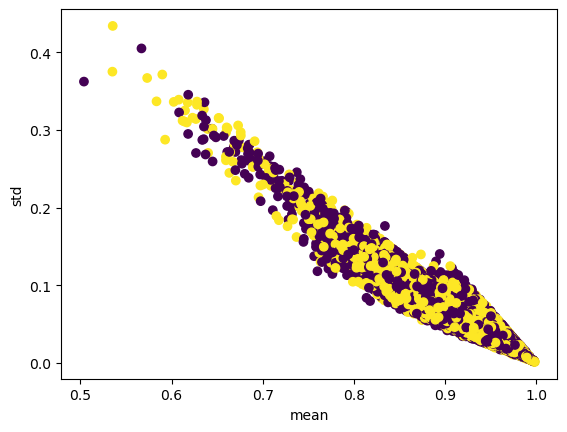

In [5]:
visualize(train)

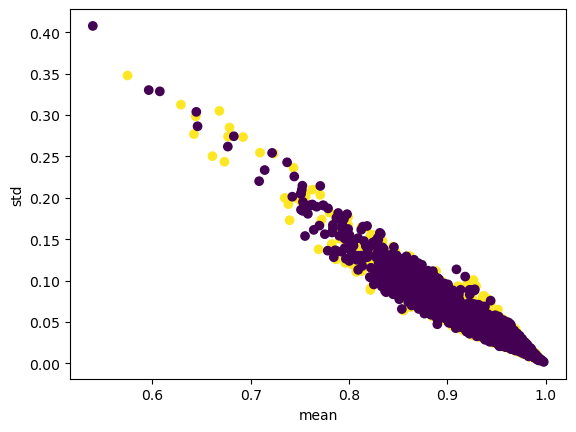

In [6]:
visualize(val)

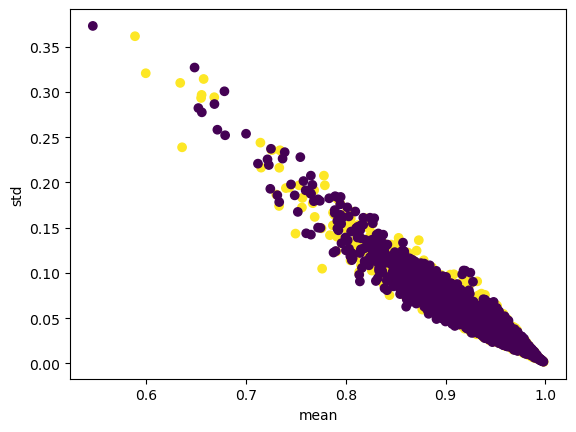

In [7]:
visualize(test)

## Evaluation

In [8]:
def classify(classifier, train, test):
    classifier.fit(train[:,:-1], train[:,-1])
    pred=classifier.predict(test[:,:-1])
    print(classification_report(test[:,-1],pred))
    RocCurveDisplay.from_estimator(classifier,test[:,:-1],test[:,-1])
    plt.show()

              precision    recall  f1-score   support

         0.0       0.50      0.61      0.55      2000
         1.0       0.49      0.38      0.43      2000

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.49      4000
weighted avg       0.50      0.50      0.49      4000



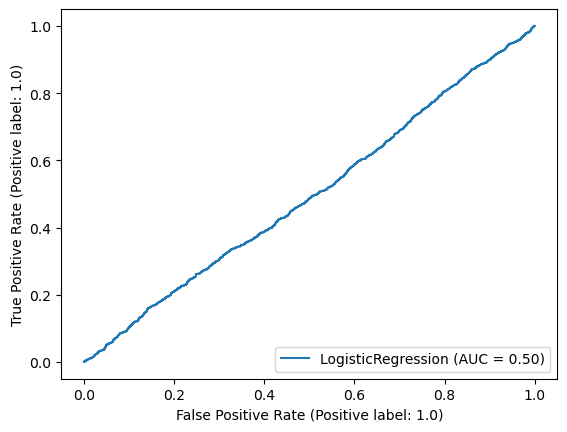

In [9]:
classify(LogisticRegression(),train,test)

              precision    recall  f1-score   support

         0.0       0.50      0.72      0.59      2000
         1.0       0.50      0.28      0.36      2000

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.47      4000
weighted avg       0.50      0.50      0.47      4000



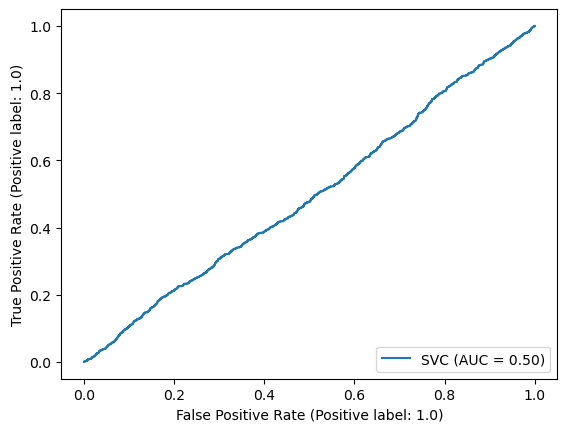

In [10]:
classify(SVC(),train,test)

              precision    recall  f1-score   support

         0.0       0.50      0.52      0.51      2000
         1.0       0.50      0.49      0.50      2000

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.50      4000
weighted avg       0.50      0.50      0.50      4000



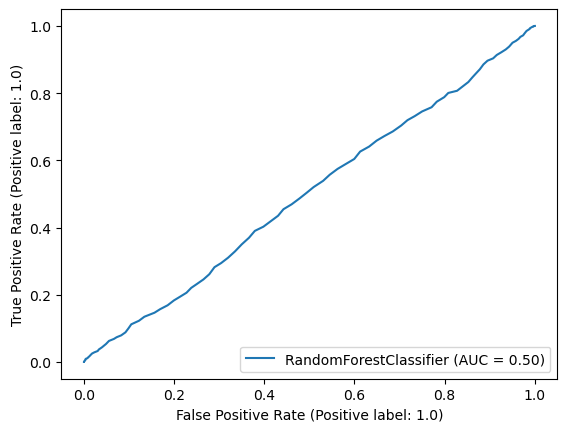

In [11]:
classify(RandomForestClassifier(),train,test)

              precision    recall  f1-score   support

         0.0       0.50      0.55      0.52      2000
         1.0       0.50      0.46      0.48      2000

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.50      4000
weighted avg       0.50      0.50      0.50      4000



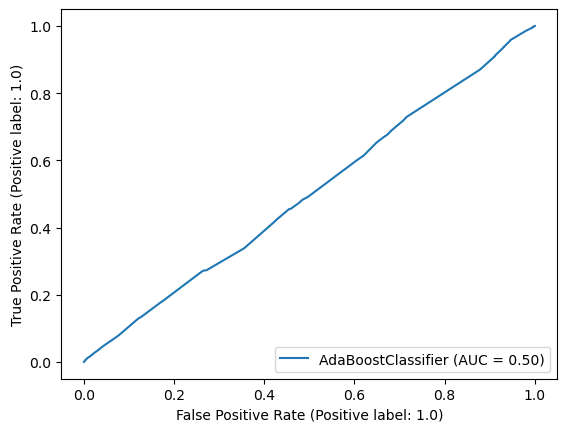

In [12]:
classify(AdaBoostClassifier(),train,test)

              precision    recall  f1-score   support

         0.0       0.51      0.60      0.55      2000
         1.0       0.51      0.41      0.46      2000

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.50      4000
weighted avg       0.51      0.51      0.50      4000



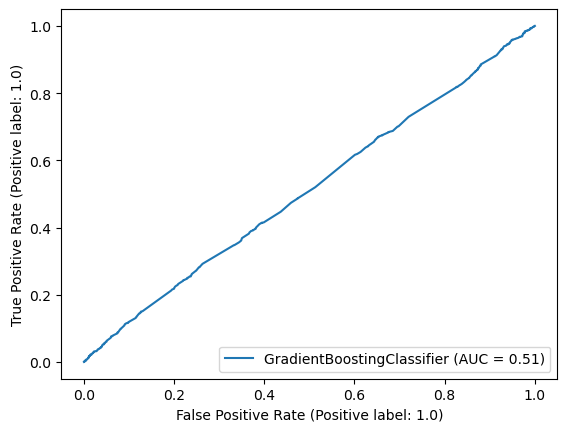

In [13]:
classify(GradientBoostingClassifier(),train,test)

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      2000
         1.0       0.67      0.00      0.00      2000

    accuracy                           0.50      4000
   macro avg       0.58      0.50      0.33      4000
weighted avg       0.58      0.50      0.33      4000



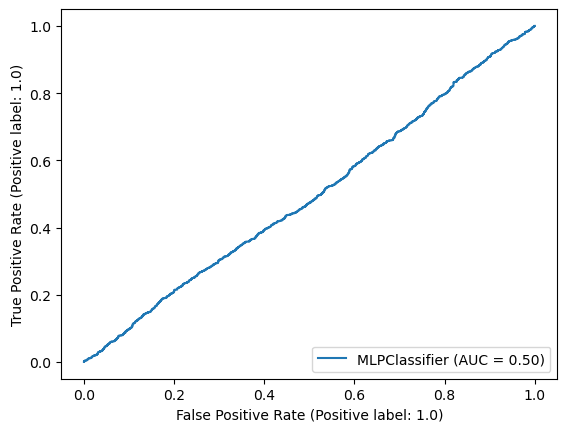

In [14]:
classify(MLPClassifier(),train,test)